# Data Pipeline

<p align='center'><img width="1000" src="https://drive.google.com/uc?export=view&id=1jJBTwowiOJSC464L9GNCC5csyD4e_6nz"></p>


## Setup

In [1]:
!pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11695 sha256=68f111ffccb6119efdbb1f221ab5744d2738c595e1e74ee04cfc7e9f8f4070b8
  Stored in directory: /root/.cache/pip/wheels/07/93/05/72c05349177dca2e0ba31a33ba4f7907606f7ddef303517c6a
Successfully built wikipedia


In [2]:
# import the necessary packages
import logging
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
sns.set()

In [3]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Creating the graph

This function gets a `SEED` and the `STOPS` to extract the pages and create a graph.

In [4]:
def create_graph(args: dict) -> nx.DiGraph:
  logger.info("[INFO] Creating graph")

  # organizating the search
  todo_lst = [(0, args['SEED'])] # The SEED is in the layer 0
  todo_set = set(args['SEED']) # The SEED itself
  done_set = set() # Nothing is done yet

  # creating the initial graph
  g = nx.DiGraph()
  layer, page = todo_lst[0]

  if os.path.isfile('extract.txt'):
    file = open('extract.txt', 'w')
  else:
    file = open('extract.txt', 'x')
    
  while layer < 2:
    # Remove the name page of the current page from the todo_lst, 
    # and add it to the set of processed pages. 
    # If the script encounters this page again, it will skip over it.
    del todo_lst[0]
    done_set.add(page)
    
    # Show progress
    # print(layer, page)
    file.write(f"{layer} {page}\n")
    
    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      # print("Could not load", page)
      file.write("Could not load\n")
      layer, page = todo_lst[0]
      continue
    
    for link in wiki.links:
      link = link.title()
      if link not in args['STOPS'] and not link.startswith("List Of"):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]

  # close the file
  file.close()
  
  return g

## Preprocessing

Some nodes come as duplicates but in plural or with `-` between the words. For example, `Mark Shield` and `Mark Shields` or even `High-Fructose Corn Syrup` and `High Fructose Corn Syrup`. So, this function search these nodes and contract them into only one.

In [5]:
def preprocessing(g: nx.DiGraph) -> nx.DiGraph:
  logger.info("[INFO] Starting preprocessing")

  g.remove_edges_from(nx.selfloop_edges(g))

  # identify duplicates like that: 'network' and 'networks'
  duplicates = [(node, node + "s") 
                for node in g if node + "s" in g
              ]

  for dup in duplicates:
    # *dup is a technique named 'unpacking'
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  if os.path.isfile('preprocessing.txt'):
    file2 = open('preprocessing.txt', 'w')
  else:
    file2 = open('preprocessing.txt', 'x')

  # print(duplicates) # we can remove this line in the future
  file2.write(f"{duplicates}")

  duplicates = [(x, y) for x, y in 
                [(node, node.replace("-", " ")) for node in g]
                  if x != y and y in g]

  # print(duplicates) # we can remove this line in the future
  file2.write(f"{duplicates}")
  file2.close()

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  # nx.contracted creates a new node/edge attribute called contraction
  # the value of the attribute is a dictionary, but GraphML
  # does not support dictionary attributes
  nx.set_node_attributes(g, 0,"contraction")
  nx.set_edge_attributes(g, 0,"contraction")

  file2.close()
  return g

## Truncate the network

Most of the nodes in this network have only one connection. So, this function removes these nodes with only one incident edge to make the network more compact and less hairy without hurting the final results

In [6]:
def plot_histogram(g: nx.DiGraph):
  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

  fig, ax = plt.subplots(1,2,figsize=(8,4))

  # all_data has information about degree_sequence and the width of each bin
  ax[0].hist(degree_sequence)
  ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")
  ax[0].set_ylim(0,15000)

  ax[1].set_title("Degree Histogram - Zoom")
  ax[1].set_ylabel("Count")
  ax[1].set_xlabel("Degree")
  ax[1].set_xlim(0,10)
  ax[1].set_ylim(0,15000)

  plt.tight_layout()
  plt.savefig('degree_hist.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [7]:
def truncate(g: nx.DiGraph):
  logger.info("[INFO] Starting to truncate the network")

  # checking the degree for each node
  plot_histogram(g)

  # filter nodes with degree greater than or equal to 2
  core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

  # select a subgraph with 'core' nodes
  gsub = nx.subgraph(g, core)

  logger.info("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

  # reporting the final graph
  nx.write_graphml(gsub, "cna.graphml")

  logger.info("Nodes removed: {:.2f}%".format(100*(1 - len(gsub)/len(g))))
  logger.info("Edges removed: {:.2f}%".format(100*(1 - nx.number_of_edges(gsub)/nx.number_of_edges(g))))
  logger.info("Edges per nodes: {:.2f}".format(nx.number_of_edges(gsub)/len(gsub)))

## Exploring the network

### Most significant nodes and number of connections

In [8]:
def most_significant_nodes(g: nx.DiGraph):
  logger.info("[INFO] Getting the most significant nodes")
  # getting the most significant nodes with their respective number of connections
  top_indegree = sorted(dict(g.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]

  # writing in a file
  if os.path.isfile('most_sig_nodes.txt'):
    file3 = open('most_sig_nodes.txt', 'w')
  else:
    file3 = open('most_sig_nodes.txt', 'x')

  file3.write("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))
  file3.close()

### Degree, closeness, betweenness and eigenvector centrality

Since this network is very large, in order to visualize these metrics, it was necessary to use a tool called [Gephi](https://gephi.org/) to improve the visualization. However, below is the code that allows you to view these metrics using Python functions from the `networkx` and `matplotlib` libraries.

#### Centrality distributions - Degree

In [9]:
def all_nodes_degree(g: nx.DiGraph):
  logger.info("[INFO] Exploring Centrality distributions - Degree - All Nodes")
  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

  fig, ax = plt.subplots(1,2,figsize=(8,4))

  # all_data has information about degree_sequence and the width of each bin
  all_data = ax[0].hist(degree_sequence,bins=7)
  ax[1].hist(degree_sequence,bins=7,density=True)

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")

  ax[1].set_title("Probability Density Function")
  ax[1].set_ylabel("Probability")
  ax[1].set_xlabel("Degree")

  plt.tight_layout()
  plt.savefig('degree_all_hist.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  logger.info(f"[INFO] all_data: {all_data}")
  logger.info(f"[INFO] all_data[1]: {all_data[1]}")
  logger.info(f"[INFO] diff(all_data[1]): {np.diff(all_data[1])}")
  logger.info(f"[INFO] all_data[0].sum(): {all_data[0].sum()}")
  logger.info(f"[INFO] all_data[0]/(all_data[0].sum() * np.diff(all_data[1])): {all_data[0]/(all_data[0].sum() * np.diff(all_data[1]))}")

  # plot Probability Density Function (PDF)
  logger.info("[INFO] Ploting Probability Density Function (PDF) - All Nodes")
  plt.style.use("fivethirtyeight")

  fig, ax = plt.subplots(1,1,figsize=(7,6))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('probability_density_function_all_nodes.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  # plot Cumulative Density Function (CDF)
  logger.info("[INFO] Ploting Cumulative Density Function (CDF) - All Nodes")
  fig, ax = plt.subplots(1,1,figsize=(7,6))
  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('cumulative_density_function_all_nodes.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [10]:
def degree_over_100(g: nx.DiGraph):
  logger.info("[INFO] Exploring Centrality distributions - Degree - Nodes with degree greater than or equal to 100")
  # filter nodes with degree greater than or equal to 100
  core = [node for node, deg in dict(g.degree()).items() if deg > 100]

  # select a subgraph with 'core' nodes
  gsub = nx.subgraph(g, core)

  logger.info("[INFO] {} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([d for n, d in gsub.degree()], reverse=True)  

  fig, ax = plt.subplots(1,2,figsize=(8,6))

  # all_data has information about degree_sequence and the width of each bin
  all_data = ax[0].hist(degree_sequence,bins=7)
  ax[1].hist(degree_sequence,bins=7,density=True)

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")

  ax[1].set_title("Probability Density Function")
  ax[1].set_ylabel("Probability")
  ax[1].set_xlabel("Degree")

  plt.tight_layout()
  plt.savefig('degree_100_hist.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  # plot Probability Density Function (PDF)
  logger.info("[INFO] Ploting Probability Density Function (PDF) - Nodes 100")
  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots(1,1,figsize=(7,6))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('probability_density_function_nodes_100.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  # plot Cumulative Density Function (CDF)
  logger.info("[INFO] Ploting Cumulative Density Function (CDF) - Nodes 100")
  fig, ax = plt.subplots(1,1,figsize=(7,6))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('cumulative_density_function_nodes_100.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [11]:
def degree(g: nx.DiGraph):
  logger.info("[INFO] Exploring Centrality distributions - Degree")
  all_nodes_degree(g)
  degree_over_100(g)

#### Centrality distributions - Closeness

In [12]:
def closeness(g: nx.DiGraph):
  logger.info("[INFO] Exploring Centrality distributions - Closeness")
  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([v for k, v in nx.closeness_centrality(g).items()], reverse=True)  

  fig, ax = plt.subplots(1,2,figsize=(8,4))

  # all_data has information about degree_sequence and the width of each bin
  all_data = ax[0].hist(degree_sequence,bins=7)
  ax[1].hist(degree_sequence,bins=7,density=True)

  ax[0].set_title("Closeness centrality Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Closeness centrality")

  ax[1].set_title("Probability Density Function")
  ax[1].set_ylabel("Probability")
  ax[1].set_xlabel("Closeness centrality")

  plt.tight_layout()
  plt.savefig('closeness_all_hist.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  # plot Probability Density Function (PDF)
  logger.info("[INFO] Ploting Probability Density Function (PDF) - Closeness")
  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots(1,1,figsize=(7,6))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Closeness centrality")
  ax2.set_ylabel("Probability")
  plt.savefig('probability_density_function_closeness.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  # plot Cumulative Density Function (CDF)
  logger.info("[INFO] Ploting Cumulative Density Function (CDF) - Closeness")
  fig, ax = plt.subplots(1,1,figsize=(7,6))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Closeness centrality")
  ax2.set_ylabel("Probability")

  plt.savefig('cumulative_density_function_closeness.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

### All metrics together

In [13]:
def all_metrics(g: nx.DiGraph):
  logger.info("[INFO] Exploring all metrics together")
  dc = pd.Series(nx.degree_centrality(g))
  ec = pd.Series(nx.eigenvector_centrality(g))
  cc = pd.Series(nx.closeness_centrality(g))

  df = pd.DataFrame.from_dict({"Degree": dc,
                              "EigenVector": ec,
                              "Closeness": cc})
  df = df.reset_index(drop=True)

  fig = sns.PairGrid(df)
  fig.map_upper(sns.scatterplot)
  fig.map_lower(sns.kdeplot, cmap="Reds_r")
  fig.map_diag(sns.kdeplot, lw=2, legend=False)

  plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
  plt.show()

### Core composition

In [14]:
def core_composition(g: nx.DiGraph):
  logger.info("[INFO] Exploring core composition")
  # how many k-cores does this network have
  k_cores = set([v for k,v in nx.core_number(g).items()])

  logger.info(f"[INFO] K-cores: {k_cores}")
  logger.info(f"[INFO] K-cores length: {len(k_cores)}")

  # who are in the innermost k-core
  k_shell = list(nx.k_shell(g, 168))

  logger.info(f"[INFO] K-shell: {k_shell}")

  if os.path.isfile('k_shell.txt'):
    file4 = open('k_shell.txt', 'w')
  else:
    file4 = open('k_shell.txt', 'x')

  for shell in k_shell:
    file4.write(f"{shell}\n")

  file4.close()

In [15]:
def explore_network(g: nx.DiGraph):
  g = nx.read_graphml('cna.graphml')
  most_significant_nodes(g)
  degree(g)
  closeness(g)
  all_metrics(g)
  core_composition(g)

## Composing the functions

We must put all pipeline steps into functions to use `compose()`. This function gets the output from first funcion and pass as argument to next. 

In [16]:
def compose (*functions):
    def inner(arg):
        for f in functions:
            arg = f(arg)
        return arg
    return inner

In [17]:
# setup seed and stops
SEED = "2022 FIFA World Cup".title()
STOPS = ("FIFA",
         "FIFA 2022",
         "FIFA World Cup",
         "2022 tournament")

args = {
    'SEED': SEED,
    'STOPS': STOPS
}

08-12-2022 13:30:07 [INFO] Creating graph
/usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
08-12-2022 13:35:42 [INFO] Starting preprocessing
08-12-2022 13:39:28 [INFO] Starting to truncate the network


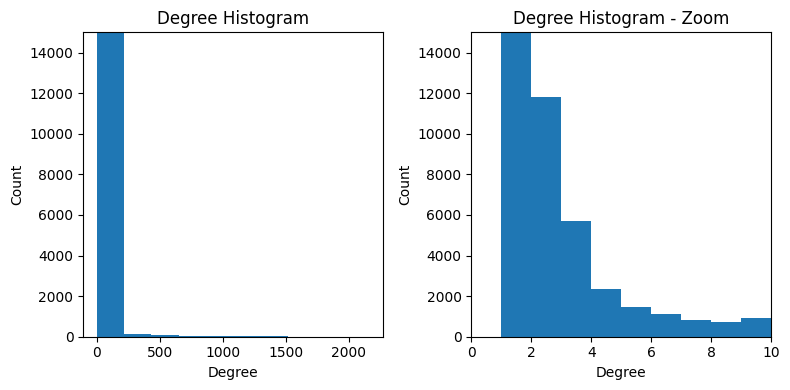

08-12-2022 13:39:31 27537 nodes, 163982 edges
08-12-2022 13:39:35 Nodes removed: 65.58%
08-12-2022 13:39:36 Edges removed: 24.24%
08-12-2022 13:39:37 Edges per nodes: 5.95
08-12-2022 13:39:42 [INFO] Getting the most significant nodes
08-12-2022 13:39:42 [INFO] Exploring Centrality distributions - Degree
08-12-2022 13:39:42 [INFO] Exploring Centrality distributions - Degree - All Nodes


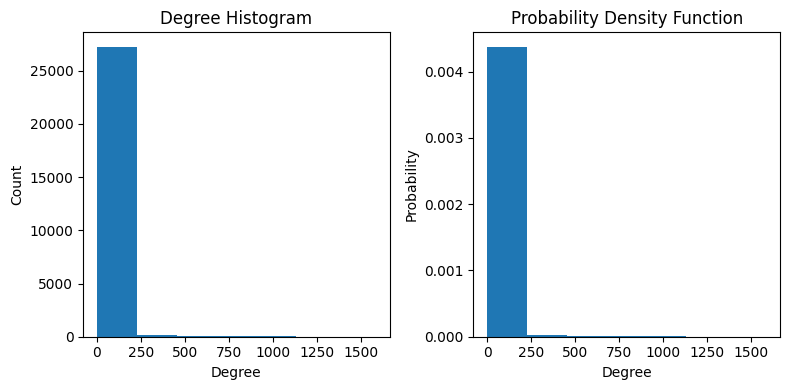

08-12-2022 13:39:44 [INFO] all_data: (array([2.7255e+04, 1.3100e+02, 7.0000e+01, 3.7000e+01, 2.9000e+01,
       1.0000e+01, 5.0000e+00]), array([   2.        ,  228.28571429,  454.57142857,  680.85714286,
        907.14285714, 1133.42857143, 1359.71428571, 1586.        ]), <a list of 7 Patch objects>)
08-12-2022 13:39:44 [INFO] all_data[1]: [   2.          228.28571429  454.57142857  680.85714286  907.14285714
 1133.42857143 1359.71428571 1586.        ]
08-12-2022 13:39:44 [INFO] diff(all_data[1]): [226.28571429 226.28571429 226.28571429 226.28571429 226.28571429
 226.28571429 226.28571429]
08-12-2022 13:39:44 [INFO] all_data[0].sum(): 27537.0
08-12-2022 13:39:44 [INFO] all_data[0]/(all_data[0].sum() * np.diff(all_data[1])): [4.37393600e-03 2.10231376e-05 1.12337377e-05 5.93783277e-06
 4.65397704e-06 1.60481967e-06 8.02409834e-07]
08-12-2022 13:39:44 [INFO] Ploting Probability Density Function (PDF) - All Nodes


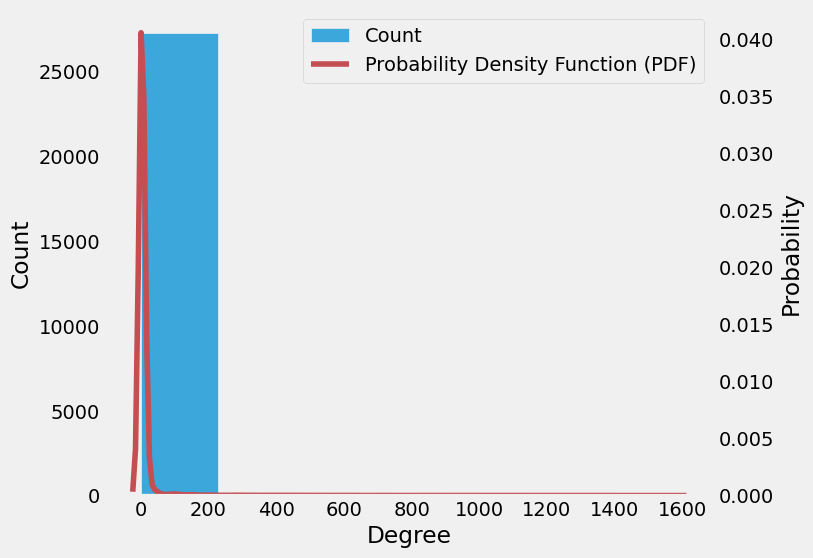

08-12-2022 13:39:48 [INFO] Ploting Cumulative Density Function (CDF) - All Nodes


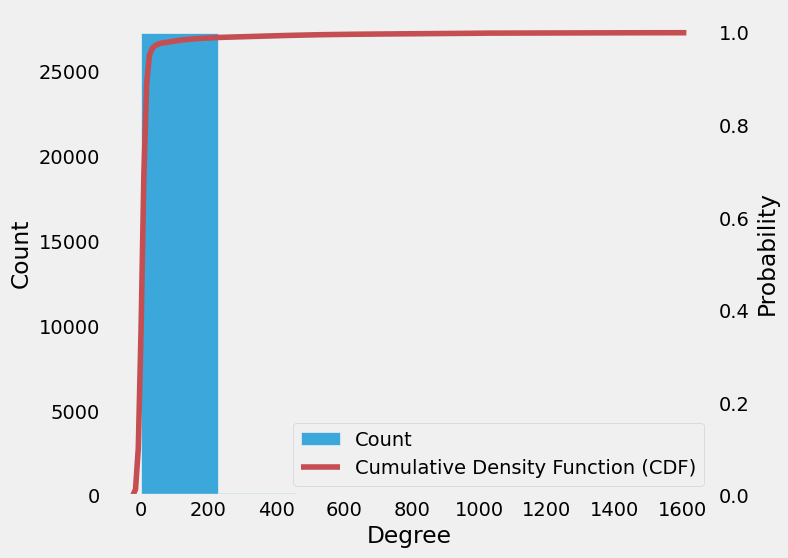

08-12-2022 13:39:51 [INFO] Exploring Centrality distributions - Degree - Nodes with degree greater than or equal to 100
08-12-2022 13:39:51 [INFO] 496 nodes, 31878 edges


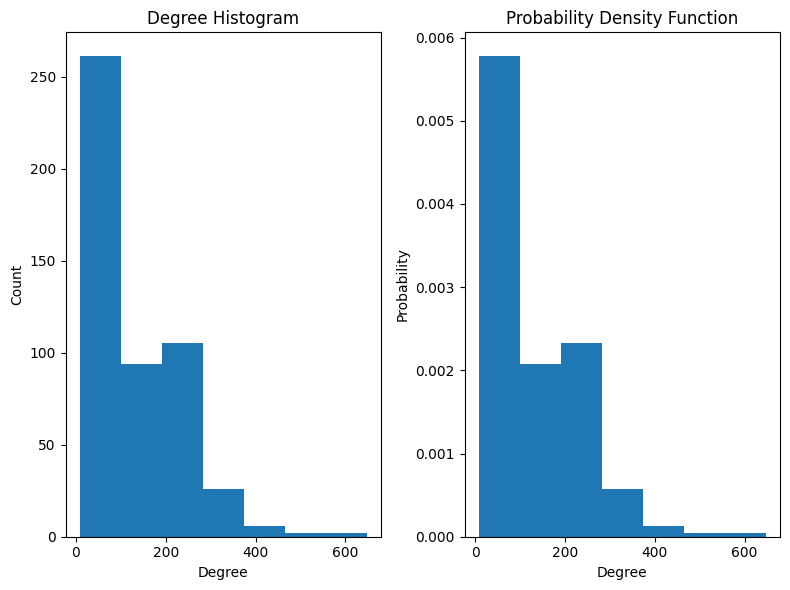

08-12-2022 13:39:54 [INFO] Ploting Probability Density Function (PDF) - Nodes 100


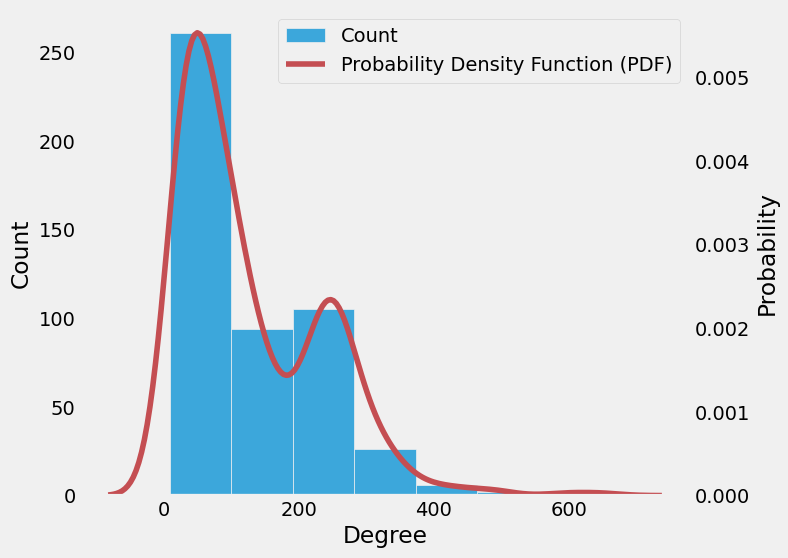

08-12-2022 13:39:56 [INFO] Ploting Cumulative Density Function (CDF) - Nodes 100


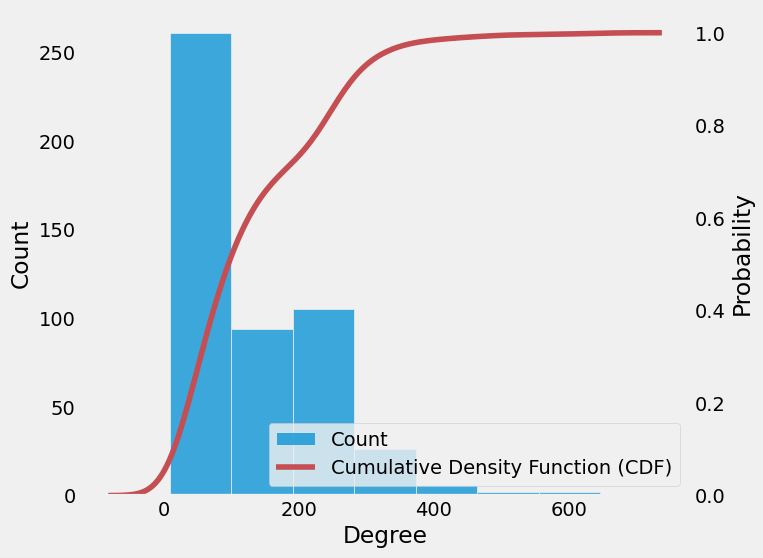

08-12-2022 13:39:59 [INFO] Exploring Centrality distributions - Closeness


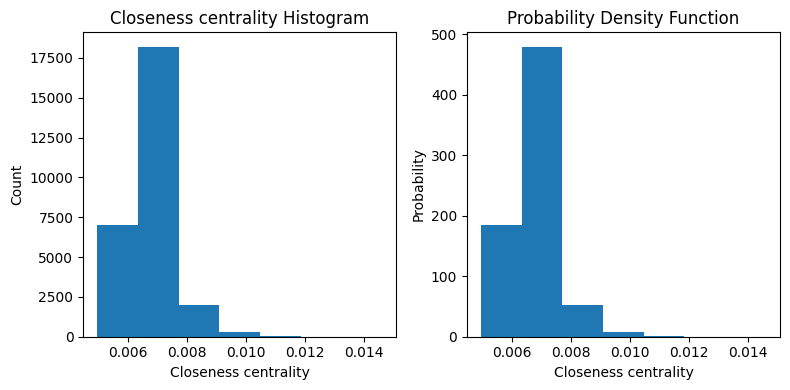

08-12-2022 13:40:38 [INFO] Ploting Probability Density Function (PDF) - Closeness


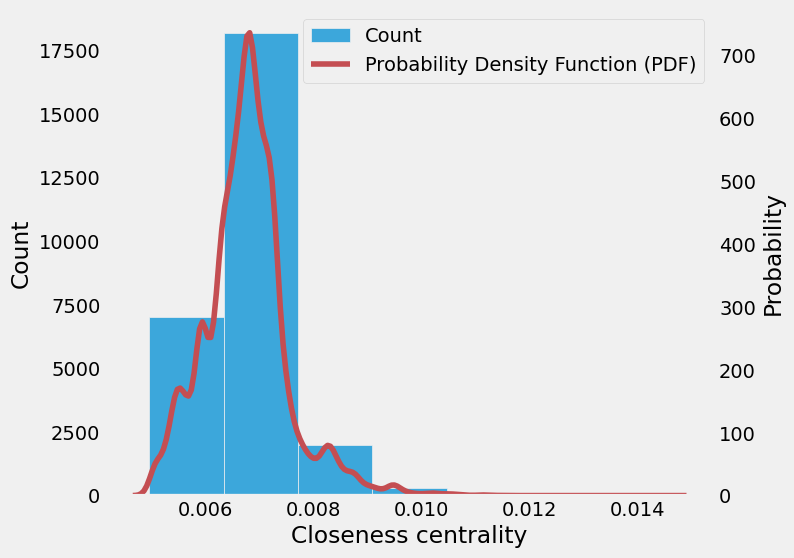

08-12-2022 13:40:40 [INFO] Ploting Cumulative Density Function (CDF) - Closeness


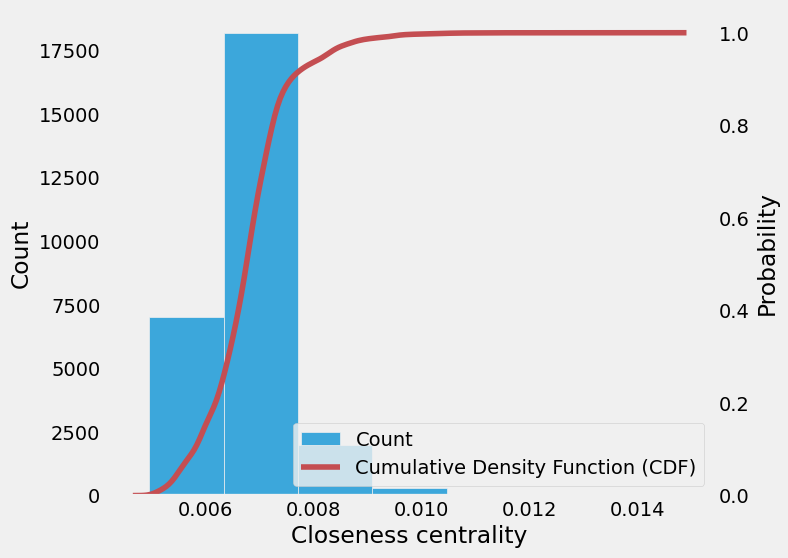

08-12-2022 13:40:44 [INFO] Exploring all metrics together


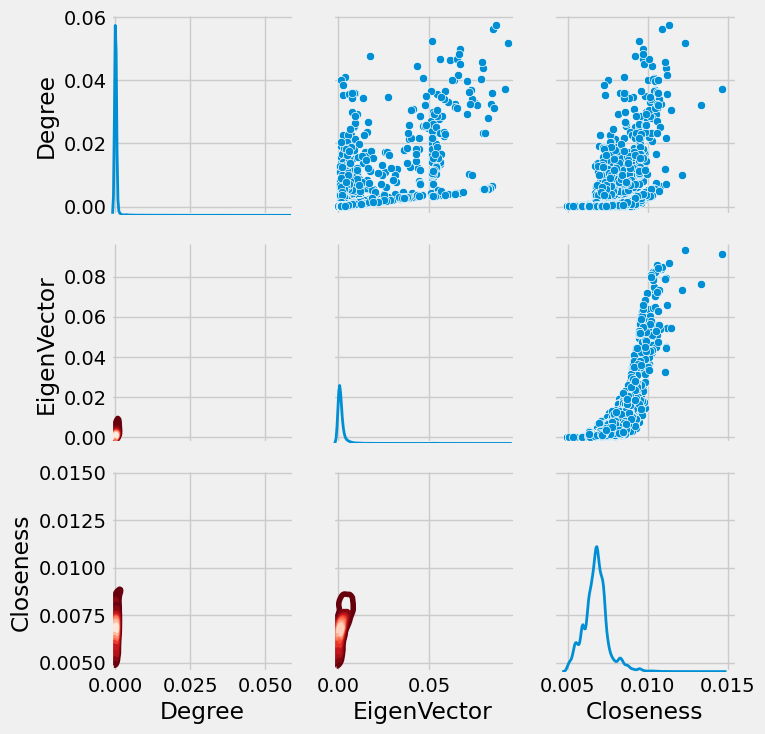

08-12-2022 13:42:50 [INFO] Exploring core composition
08-12-2022 13:42:53 [INFO] K-cores: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 84, 85, 86, 87, 88, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 109, 110, 111, 112, 114, 118, 121, 126, 168}
08-12-2022 13:42:53 [INFO] K-cores length: 105
08-12-2022 13:42:55 [INFO] K-shell: ['European Nations At The Fifa World Cup', 'North, Central American And Caribbean Nations At The Fifa World Cup', '1962 Fifa World Cup Final', '1954 Fifa World Cup Qualification', '2010 Fifa World Cup', "1980 World Champions' Gold Cup", '2018 Fifa World Cup Statistics', '1998 Fifa World Cup Broadcasting Rights', '2014 Fifa World Cup Seeding', 'Fifa World Cup Hosts', '2014 Fifa World Cup Statistics

In [18]:
composed = compose(create_graph, preprocessing, truncate, explore_network)
composed(args)